In [1]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.1/880.1 kB 12.0 MB/s eta 0:00:0000:0100:01


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Using TensorFlow backend
TensorFlow version: 2.12.0
KerasNLP version: 0.6.1


# Load dataset

In [3]:
import torch
from torch.utils.data import DataLoader
from datasets import Dataset, DatasetDict, load_dataset

In [4]:
from datasets import load_dataset, DatasetDict
imdb_dataset = load_dataset("PKU-Alignment/BeaverTails")
columns_to_drop = ["prompt", "category"]

for split in imdb_dataset.keys():
    print(split)
    for column in columns_to_drop:
        imdb_dataset[split] = imdb_dataset[split].remove_columns(column)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/PKU-Alignment--BeaverTails-99b88799c14c11ec/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

train
test


In [5]:
imdb_dataset['train'] = imdb_dataset['train'].rename_column('response', 'text')
imdb_dataset['train'] = imdb_dataset['train'].rename_column('is_safe','target')

imdb_dataset['test'] = imdb_dataset['test'].rename_column('response', 'text')
imdb_dataset['test'] = imdb_dataset['test'].rename_column('is_safe','target')

In [6]:
#train_dataset.features

from datasets import ClassLabel, Value
new_features = imdb_dataset['train'].features.copy()
new_features["target"] = ClassLabel(names=["MALICIOUS", "BENIGN"])
new_features["target"] = Value('int64')
imdb_dataset['train'] = imdb_dataset['train'].cast(new_features)

Casting the dataset:   0%|          | 0/31 [00:00<?, ?ba/s]

In [7]:
new_features = imdb_dataset['test'].features.copy()
new_features["target"] = ClassLabel(names=["MALICIOUS", "BENIGN"])
new_features["target"] = Value('int64')
imdb_dataset['test'] = imdb_dataset['test'].cast(new_features)

Casting the dataset:   0%|          | 0/4 [00:00<?, ?ba/s]

In [8]:
import pandas as pd
train_data = imdb_dataset['train']
test_data = imdb_dataset['test']

## Merge custome data with train data

In [9]:
test_data = pd.DataFrame(test_data)

In [10]:
train_data = pd.DataFrame(train_data)

In [11]:
test_data = test_data.drop(['target'], axis=1)

In [12]:
import torch
from torch.utils.data import DataLoader
from datasets import Dataset, DatasetDict, load_dataset

In [13]:
df_train = train_data  
df_test = test_data  

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (300567, 2)
Training Set Memory Usage = 4.59 MB
Test Set Shape = (33396, 1)
Test Set Memory Usage = 0.25 MB


# Explore the dataset

In [14]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    300567.000000
mean        349.051243
std         226.191835
min           1.000000
25%         175.000000
50%         325.000000
75%         479.000000
max        2314.000000
Name: length, dtype: float64

Test Length Stat
count    33396.000000
mean       348.531920
std        221.431729
min          2.000000
25%        176.000000
50%        327.000000
75%        481.000000
max       1977.000000
Name: length, dtype: float64


# Preprocess the data

In [15]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 5
AUTO = tf.data.experimental.AUTOTUNE

In [16]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)
X_test = df_test["text"]

# Load a DistilBERT model from Keras NLP

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT.

The BertClassifier model can be configured with a preprocessor layer, in which case it will automatically apply preprocessing to raw inputs during fit(), predict(), and evaluate(). This is done by default when creating the model with from_preset().

In [17]:
preset= "distil_bert_base_en_uncased"
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor")
# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor, 
                                                               num_classes=2)
classifier.summary()

231508/231508 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step       
265570304/265570304 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Preprocessor: "preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │  66,362,880 │ padding_mask[0][0],            │
│ (DistilBertBackbone)          │                           │             │ token_ids[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │           0 │ distil_bert_backbone[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │     590,592 │ get_item[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 768)               │           0 │ pooled_dense[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │       1,538 │ classifier_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────┴────────────────────────────────┘

 Total params: 66,955,010 (2.00 GB)

 Trainable params: 66,955,010 (2.00 GB)

 Non-trainable params: 0 (0.00 B)

# Train your own model, fine-tuning BERT

In [18]:
# Compile
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #'binary_crossentropy',
    optimizer=keras.optimizers.Adam(1e-5),
    metrics= ["accuracy"]  
)

# Fit
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS, 
                         validation_data=(X_val, y_val))

Epoch 1/5
7515/7515 ━━━━━━━━━━━━━━━━━━━━ 3336s 436ms/step - accuracy: 0.7912 - loss: 0.4362 - val_accuracy: 0.8380 - val_loss: 0.3635
Epoch 2/5
7515/7515 ━━━━━━━━━━━━━━━━━━━━ 3234s 430ms/step - accuracy: 0.8480 - loss: 0.3444 - val_accuracy: 0.8449 - val_loss: 0.3562
Epoch 3/5
7515/7515 ━━━━━━━━━━━━━━━━━━━━ 3274s 436ms/step - accuracy: 0.8661 - loss: 0.3105 - val_accuracy: 0.8464 - val_loss: 0.3632
Epoch 4/5
7515/7515 ━━━━━━━━━━━━━━━━━━━━ 3234s 430ms/step - accuracy: 0.8761 - loss: 0.2842 - val_accuracy: 0.8445 - val_loss: 0.3816
Epoch 5/5
7515/7515 ━━━━━━━━━━━━━━━━━━━━ 3275s 436ms/step - accuracy: 0.8829 - loss: 0.2646 - val_accuracy: 0.8430 - val_loss: 0.4146


In [19]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),#"MALICIOUS", "BENIGN"
        display_labels=["MALICIOUS","BENIGN"],
        cmap=plt.cm.Blues)

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))
    precision = tp/(tp+fp)
    recall = tp/(tp+tn)

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset \n-- F1 Score: " + str(f1_score.round(2))+ "\n-- Precision: "+str(precision.round(2))+  "\n-- Recall: "+str(recall.round(2)))

7515/7515 ━━━━━━━━━━━━━━━━━━━━ 972s 129ms/step


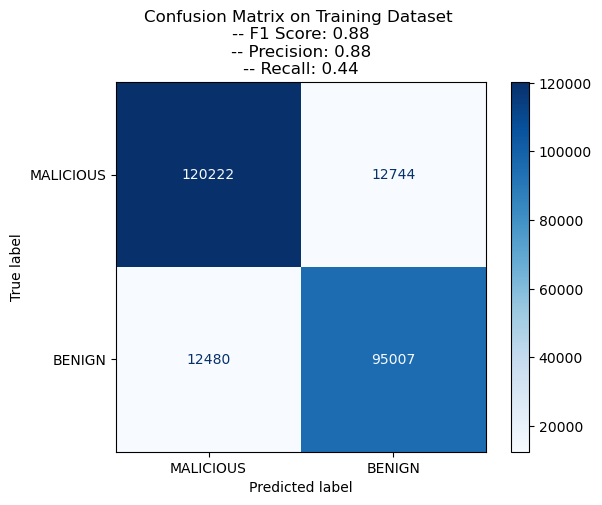

In [20]:
y_pred_train = classifier.predict(X_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")

1879/1879 ━━━━━━━━━━━━━━━━━━━━ 245s 130ms/step


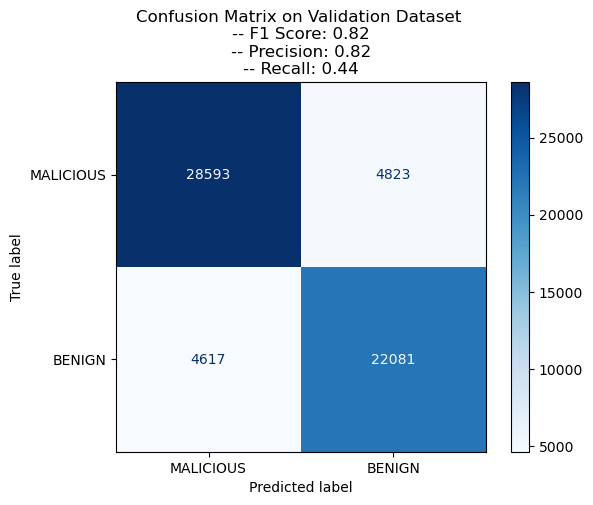

In [21]:
y_pred_val = classifier.predict(X_val)
displayConfusionMatrix(y_val, y_pred_val, "Validation")

## Save the model and make some predictions

In [22]:
classifier.save('classifier_mb.keras')

In [23]:
from keras.models import load_model

# Load the Keras model
model = tf.keras.models.load_model('/kaggle/working/classifier_mb.keras')

# Summary of the model architecture
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/saving/serialization_lib.py:508: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)


Preprocessor: "preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │  66,362,880 │ padding_mask[0][0],            │
│ (DistilBertBackbone)          │                           │             │ token_ids[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ get_item_1 (GetItem)          │ (None, 768)               │           0 │ distil_bert_backbone[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │     590,592 │ get_item_1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 768)               │           0 │ pooled_dense[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │       1,538 │ classifier_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────┴────────────────────────────────┘

 Total params: 66,955,010 (2.00 GB)

 Trainable params: 66,955,010 (2.00 GB)

 Non-trainable params: 0 (0.00 B)

In [24]:
def predict(text):
    class_labels = {0: 'MALICIOUS', 1: 'BENIGN'}
    predeition = model.predict(text)
    prediction_label = class_labels[np.argmax(predeition)]
    return prediction_label